# Random Forest - Open-world Multi Scenario

**최적 Feature 조합**: 영채 (17개 features)
- **성능**: Accuracy 86.93%, F1-Score 85.65% (Macro)
- **시나리오**: 95개 Monitored 사이트 + 1개 Unmonitored 클래스 (총 96개 클래스)

## Feature 구성
- **Basic Features (5개)**: 전송 시간, 패킷 간격, 패킷 수, 패킷 비율
- **Burst Features (2개)**: 송수신 버스트 크기
- **Cumulative Features (3개)**: 누적 패킷 수, 최대값
- **Order Skew Features (2개)**: 송수신 순서 왜도
- **First 30 Features (4개)**: 첫 30개 패킷 특성
- **Bigram Features (1개)**: 연속 패킷 패턴

이는 Closed-world 조합에 bigram 특성을 추가한 확장 버전입니다.


## 1. 라이브러리 및 데이터 로드


In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [ ]:
# Load monitored features
MON_FILE_PATH = '../../../content/mon_features.pkl'
UNMON_FILE_PATH = '../../../content/unmon_features.pkl'

print("Monitored 데이터 로드 중...")
mon_features = pd.read_pickle(MON_FILE_PATH)
print(f"Monitored 데이터 형태: {mon_features.shape}")

# Load unmonitored features
print("\nUnmonitored 데이터 로드 중...")
unmon_features = pd.read_pickle(UNMON_FILE_PATH)
print(f"Unmonitored 데이터 형태: {unmon_features.shape}")
print("데이터 로드 완료!")


Monitored 데이터 로드 중...
Monitored 데이터 형태: (19000, 19)

Unmonitored 데이터 로드 및 처리 중...
Unmonitored 데이터 형태: (3000, 18)
데이터 로드 완료!


## 2. 최적 Feature 조합 정의


In [3]:
# 영채의 최적 feature 조합 (17개) - Open-world multi에서 최고 성능
yc_basic = ['total_transmission_time', 'std_inter_packet_time', 
            'num_outgoing_packets', 
            'incoming_packet_ratio', 'outgoing_packet_ratio']
yc_burst = ['avg_outgoing_burst_size', 'avg_incoming_burst_size']
yc_cumul = ['cumul_packets_10pct', 'cumul_packets_30pct', 'cumul_max']
yc_orderskew = ['incoming_order_skew', 'outgoing_order_skew']
yc_first30 = ['outgoing_first_30', 'avg_incoming_order_first_30', 
              'avg_outgoing_order_first_30', 'num_incoming_first_30']
yc_bigram = ['bigram_OO']

# 최종 feature 조합 (Closed-world + bigram)
selected_features = yc_basic + yc_burst + yc_cumul + yc_orderskew + yc_first30 + yc_bigram

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

print("\nFeature 그룹별 구성:")
print(f"- Basic Features ({len(yc_basic)}개): {yc_basic}")
print(f"- Burst Features ({len(yc_burst)}개): {yc_burst}")
print(f"- Cumulative Features ({len(yc_cumul)}개): {yc_cumul}")
print(f"- Order Skew Features ({len(yc_orderskew)}개): {yc_orderskew}")
print(f"- First 30 Features ({len(yc_first30)}개): {yc_first30}")
print(f"- Bigram Features ({len(yc_bigram)}개): {yc_bigram}")


선택된 Feature 수: 17

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. num_outgoing_packets
 4. incoming_packet_ratio
 5. outgoing_packet_ratio
 6. avg_outgoing_burst_size
 7. avg_incoming_burst_size
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. cumul_max
11. incoming_order_skew
12. outgoing_order_skew
13. outgoing_first_30
14. avg_incoming_order_first_30
15. avg_outgoing_order_first_30
16. num_incoming_first_30
17. bigram_OO

Feature 그룹별 구성:
- Basic Features (5개): ['total_transmission_time', 'std_inter_packet_time', 'num_outgoing_packets', 'incoming_packet_ratio', 'outgoing_packet_ratio']
- Burst Features (2개): ['avg_outgoing_burst_size', 'avg_incoming_burst_size']
- Cumulative Features (3개): ['cumul_packets_10pct', 'cumul_packets_30pct', 'cumul_max']
- Order Skew Features (2개): ['incoming_order_skew', 'outgoing_order_skew']
- First 30 Features (4개): ['outgoing_first_30', 'avg_incoming_order_first_30', 'avg_outgoing_order_first_30', 'num_incoming_first_30']
- B

## 3. 데이터 준비 (Multi-class Classification)


In [ ]:
# Open-world multi: 95개 monitored 사이트 + 1개 unmonitored 클래스 (총 96개 클래스)
# Combine mon_features and unmon_features
features_df = pd.concat([mon_features, unmon_features], ignore_index=True)

X = features_df[selected_features]
y = features_df['website_label']

# Unmonitored 클래스는 -1로 유지 (필요시 95로 변환 가능)
# y = y.replace({-1: 95})  # K-NN처럼 95로 변환하려면 주석 해제

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"총 클래스 수: {len(np.unique(y))}")
monitored_classes = y[y >= 0].unique()
print(f"Monitored 클래스: {min(monitored_classes)}-{max(monitored_classes)} ({len(monitored_classes)}개)")
print(f"Unmonitored 클래스: -1 ({sum(y == -1)}개 샘플)")
print(f"Monitored 샘플: {sum(y >= 0)}")
print(f"Unmonitored 샘플: {sum(y == -1)}")

# 클래스별 샘플 수 확인
class_counts = pd.Series(y).value_counts().sort_index()
print(f"\n클래스별 샘플 수 (처음 10개):")
print(class_counts.head(10))
print(f"Unmonitored 클래스 (-1): {class_counts[-1]} 샘플")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")
print(f"테스트 데이터의 Unmonitored 샘플: {sum(y_test == -1)}개")


전체 샘플 수: 22000
Feature 수: 17
총 클래스 수: 96
Monitored 클래스: 0-94 (95개)
Unmonitored 클래스: -1 (3000개 샘플)
Monitored 샘플: 19000
Unmonitored 샘플: 3000

클래스별 샘플 수 (처음 10개):
-1    3000
 0     200
 1     200
 2     200
 3     200
 4     200
 5     200
 6     200
 7     200
 8     200
Name: count, dtype: int64
Unmonitored 클래스 (-1): 3000 샘플

훈련 데이터: 17600 샘플
테스트 데이터: 4400 샘플
테스트 데이터의 Unmonitored 샘플: 600개


## 4. Random Forest 모델 훈련 및 평가


In [5]:
# 최적 하이퍼파라미터 (rf_analysis.ipynb 결과 기반)
best_params = {
    'bootstrap': True, 
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 200
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Random Forest 모델 훈련
print("\nRandom Forest 모델 훈련 중...")
rf_clf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = rf_clf.predict(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("OPEN-WORLD MULTI RANDOM FOREST 결과")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print("="*60)


최적 하이퍼파라미터:
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Random Forest 모델 훈련 중...
모델 훈련 완료!

OPEN-WORLD MULTI RANDOM FOREST 결과
정확도 (Accuracy): 0.8693 (86.93%)
F1-Score (Macro): 0.8565
F1-Score (Weighted): 0.8680



Feature 중요도 (상위 10개):
                    feature  importance
       num_outgoing_packets    0.096671
avg_incoming_order_first_30    0.095102
avg_outgoing_order_first_30    0.088842
        outgoing_order_skew    0.070044
        incoming_order_skew    0.064583
    avg_incoming_burst_size    0.059365
      std_inter_packet_time    0.057198
                  bigram_OO    0.055682
        cumul_packets_30pct    0.054554
      outgoing_packet_ratio    0.052512


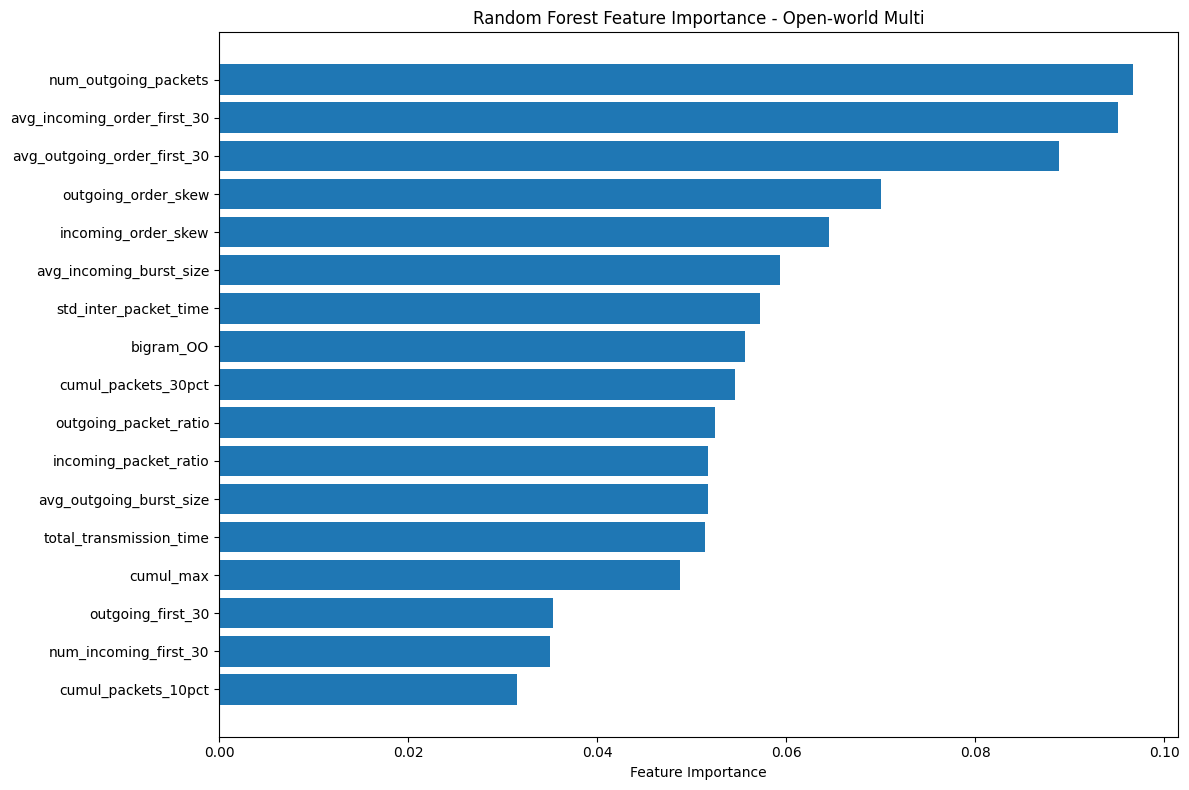


Unmonitored 클래스 정확도: 0.9667 (96.67%)
Monitored 클래스 정확도: 0.8539
Unmonitored로 잘못 분류된 Monitored 샘플: 45개
Monitored로 잘못 분류된 Unmonitored 샘플: 20개


In [6]:
# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도 (상위 10개):")
print(feature_importance.head(10).to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance - Open-world Multi')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Unmonitored 클래스 성능 분석
unmon_mask = (y_test == -1)
unmon_accuracy = accuracy_score(y_test[unmon_mask], y_pred[unmon_mask])
print(f"\nUnmonitored 클래스 정확도: {unmon_accuracy:.4f} ({unmon_accuracy*100:.2f}%)")

# Monitored vs Unmonitored 혼동 분석
monitored_mask = (y_test != -1)
print(f"Monitored 클래스 정확도: {accuracy_score(y_test[monitored_mask], y_pred[monitored_mask]):.4f}")

# Unmonitored로 잘못 분류된 Monitored 샘플 수
misclassified_as_unmon = sum((y_test != -1) & (y_pred == -1))
print(f"Unmonitored로 잘못 분류된 Monitored 샘플: {misclassified_as_unmon}개")

# Monitored로 잘못 분류된 Unmonitored 샘플 수  
misclassified_as_mon = sum((y_test == -1) & (y_pred != -1))
print(f"Monitored로 잘못 분류된 Unmonitored 샘플: {misclassified_as_mon}개")
